# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [55]:
import numpy as np
import pandas as pd
#import hvplot.pandas
import bokeh

In [56]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [57]:
# Load the fear and greed sentiment data for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
#f = df.drop(columns="fng")
df2.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,13444.879883,15306.129883,12934.160156,14754.129883,14754.129883,1956783037
2018-01-03,14754.089844,15435.009766,14579.709961,15156.620117,15156.620117,1604206990
2018-01-04,15156.490234,15408.660156,14244.669922,15180.080078,15180.080078,1656714736
2018-01-05,15180.080078,17126.949219,14832.360352,16954.779297,16954.779297,2283988962
2018-01-06,16954.759766,17252.849609,16286.570313,17172.300781,17172.300781,1412703790


In [58]:
# Load the historical closing prices for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.sort_index()
df.tail()

,fng_value,fng_classification
date,,
2019-07-25,42,Fear
2019-07-26,24,Extreme Fear
2019-07-27,47,Neutral
2019-07-28,16,Extreme Fear
2019-07-29,19,Extreme Fear


In [59]:
df.columns

Index([' fng_value', 'fng_classification'], dtype='object')

In [60]:
df = df[[" fng_value"]]
df2 = df2[["Close"]]

In [61]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [62]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [63]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [64]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [65]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling Data with `MinMaxScaler`

In [66]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [67]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.7111066 ]
  [0.68162134]
  [0.72761425]
  [0.60270722]
  [0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]]

 [[0.68162134]
  [0.72761425]
  [0.60270722]
  [0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]
  [0.58657552]]

 [[0.72761425]
  [0.60270722]
  [0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]
  [0.58657552]
  [0.68651129]]

 [[0.60270722]
  [0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]
  [0.58657552]
  [0.68651129]
  [0.64219515]]

 [[0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]
  [0.58657552]
  [0.68651129]
  [0.64219515]
  [0.7559475 ]]] 

X_test sample values:
[[[0.05471891]
  [0.04579717]
  [0.04653096]
  [0.0451359 ]
  [0.0430626 ]
  [0.04363925]
  [0.04651042]
  [0.05299984]
  [0.05299984]
  [0.08221318]]

 [[0.04579717]
  [0.04653096]
  [0.045135

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [69]:
from tensorflow import __version__
__version__

'2.8.0'

In [70]:
(X_train.shape[1], 1)

(10, 1)

In [71]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [72]:
X_train

array([[[0.7111066 ],
        [0.68162134],
        [0.72761425],
        ...,
        [0.60786209],
        [0.66058747],
        [0.64516902]],

       [[0.68162134],
        [0.72761425],
        [0.60270722],
        ...,
        [0.66058747],
        [0.64516902],
        [0.58657552]],

       [[0.72761425],
        [0.60270722],
        [0.44784942],
        ...,
        [0.64516902],
        [0.58657552],
        [0.68651129]],

       ...,

       [[0.01726567],
        [0.05168335],
        [0.05074402],
        ...,
        [0.0430626 ],
        [0.04363925],
        [0.04651042]],

       [[0.05168335],
        [0.05074402],
        [0.05471891],
        ...,
        [0.04363925],
        [0.04651042],
        [0.05299984]],

       [[0.05074402],
        [0.05471891],
        [0.04579717],
        ...,
        [0.04651042],
        [0.05299984],
        [0.05299984]]])

In [73]:
# Compile the model
model.compile(loss= 'mean_squared_error')

In [74]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 30)            3840      
                                                                 
 dropout_6 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_7 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_7 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_8 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_8 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [75]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs = 10, shuffle=False,batch_size = 1)

Epoch 1/10
372/372 [==============================] - 7s 8ms/step - loss: 0.0108
Epoch 2/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0083
Epoch 3/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0079
Epoch 4/10
372/372 [==============================] - 3s 9ms/step - loss: 0.0098
Epoch 5/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0093
Epoch 6/10
372/372 [==============================] - 4s 10ms/step - loss: 0.0108
Epoch 7/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0093
Epoch 8/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0081
Epoch 9/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0082
Epoch 10/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0083


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [76]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 5ms/step - loss: 0.2054


0.20538382232189178

In [77]:
# Make some predictions
predicted = model.predict(X_test)

In [ ]:
scaler.inverse_transform(predicted)

In [81]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [82]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,3780.767090
2019-02-21,3974.050049,3785.163574
2019-02-22,3937.040039,3791.425781
2019-02-23,3983.530029,3798.076416
2019-02-24,4149.089844,3804.701904


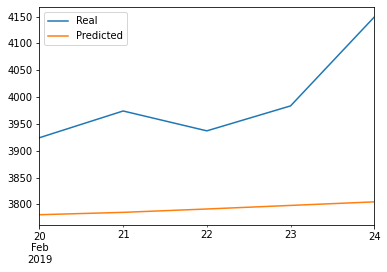

In [84]:
# Plot the real vs predicted values as a line chart
stocks.head().plot()